In [1]:
%matplotlib ipympl
import os
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
from green_gauss_theorem.vec2 import Vec2
from green_gauss_theorem.mesh import Mesh
from green_gauss_theorem.triangle import Triangle, Inflow, Outflow
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import mesh.mesh_info as mesh_info
from scipy import integrate
import pickle


def plot_mesh(mesh, variable):
    # variable = np.array(variable)/np.max(np.abs(variable))
    fig, ax = plt.subplots()
    tri_buf = []
    for t in mesh.triangles:
        tpatch = Polygon(t.get_vertex_coords(), fill=False)
        tri_buf.append(tpatch)
    tri_buf = PatchCollection(tri_buf, linewidths=0.1, edgecolors='black')
    tri_buf.set_array(variable)
    variable = np.array(variable)
    tri_buf.set_cmap('jet')
    ax.add_collection(tri_buf)
    bbox = mesh.bbox()
    ax.set_ylim(bbox[1])
    ax.set_xlim(bbox[0])
    ax.set_box_aspect((bbox[0][1] - bbox[0][0]) / (bbox[1][1] - bbox[1][0]))
    fig.colorbar(tri_buf)
    print(variable.max())
    print(variable.min())
    # plt.show()


def calculate_first_derivative(mesh, u, v, p):
    u_first_derivative_x = []
    u_first_derivative_y = []
    v_first_derivative_x = []
    v_first_derivative_y = []
    mesh.update(u, v, p)
    # TODO: move into mesh
    for tri in mesh.triangles:
        u_first_derivative = tri.u_find_first_derivative()
        v_first_derivative = tri.v_find_first_derivative()

        dudx = u_first_derivative.x
        dudy = u_first_derivative.y
        u_first_derivative_x.append(dudx)
        u_first_derivative_y.append(dudy)

        dvdx = v_first_derivative.x
        dvdy = v_first_derivative.y
        v_first_derivative_x.append(dvdx)
        v_first_derivative_y.append(dvdy)

    return u_first_derivative_x, u_first_derivative_y, v_first_derivative_x, v_first_derivative_y


def calculate_second_derivative(mesh, u, v, p):
    u_second_derivative_x = []
    u_second_derivative_y = []
    v_second_derivative_x = []
    v_second_derivative_y = []

    mesh.update(u, v, p)
    # TODO: Move into mesh
    for tri in mesh.triangles:
        u_second_derivative = tri.u_find_second_derivative()
        v_second_derivative = tri.v_find_second_derivative()

        dudxx = u_second_derivative.x
        dudyy = u_second_derivative.y
        u_second_derivative_x.append(dudxx)
        u_second_derivative_y.append(dudyy)

        dvdxx = v_second_derivative.x
        dvdyy = v_second_derivative.y
        v_second_derivative_x.append(dvdxx)
        v_second_derivative_y.append(dvdyy)

    return u_second_derivative_x, u_second_derivative_y, v_second_derivative_x, v_second_derivative_y


In [2]:
# ----------------------------------------- RESULTS READ ----------------------------------------- #
plot_check = True

TimeStep_DGNu = []
TimeStep_DGNv = []
TimeStep_DGNp = []

# mesh_contents = open('/home/damla/Desktop/Thesis/code/pod_ins/mesh/mesh_info.txt', 'r').read()
# exec(mesh_contents)

DIR = 'results'
for file_name in sorted(os.listdir(DIR)):
    file_name = os.path.join(DIR, file_name)
    result_contents = open(file_name, 'r').read()
    exec(result_contents)

    TimeStep_DGNu.append(np.array(DGNu))
    TimeStep_DGNv.append(np.array(DGNv))
    TimeStep_DGNp.append(np.array(DGNp))
    del result_contents

# ------------------------------------------ PARAMETERS ------------------------------------------ #

NUM_TIME_STEPS = len(TimeStep_DGNu)
NUM_ELEMENTS = len(TimeStep_DGNu[0])
NODES_PER_ELEMENT = len(TimeStep_DGNu[0][0])
NUM_NODES = NUM_ELEMENTS * NODES_PER_ELEMENT
NUM_POD_MODES = 6

U_INFLOW  = 1
V_INFLOW  = 0
P_INFLOW  = 0
RE        = 200
VISC      = 1/RE
FINAL_T   = 100
TIME_STEP = FINAL_T / (100 * NUM_TIME_STEPS)
TIME      = np.linspace(0, FINAL_T, NUM_TIME_STEPS)

U = np.zeros((NUM_TIME_STEPS, NUM_NODES))
V = np.zeros((NUM_TIME_STEPS, NUM_NODES))
P = np.zeros((NUM_TIME_STEPS, NUM_NODES))

# --------------------------------------------- MESH --------------------------------------------- #
mesh = Mesh(mesh_info)


In [3]:


# --------------------------------------------- POD --------------------------------------------- #
for i in range(NUM_TIME_STEPS):
    U[i, :] = TimeStep_DGNu[i].flatten()
    V[i, :] = TimeStep_DGNv[i].flatten()
    P[i, :] = TimeStep_DGNp[i].flatten()

uMean = np.mean(U, axis=0)
vMean = np.mean(V, axis=0)
pMean = np.mean(P, axis=0)

uFluc = np.zeros((NUM_TIME_STEPS, NUM_NODES))
vFluc = np.zeros((NUM_TIME_STEPS, NUM_NODES))

for t in range(NUM_TIME_STEPS):
    uFluc[t, :] = U[t, :] - uMean
    vFluc[t, :] = V[t, :] - vMean

SNAPSHOT = np.concatenate((uFluc, vFluc), axis=1)
covariance = np.cov(SNAPSHOT)

# Eigenvalues and eigenvector of correlation matrix.
eig_vals, eig_vecs = LA.eig(covariance)
eig_vals = np.real(eig_vals)
eig_vecs = np.real(eig_vecs)

# Sort eigenvalues and vectors according to abs(eig_val)
sorting_indices = np.abs(eig_vals).argsort()[::-1]
eig_vals = eig_vals[sorting_indices]
eig_vecs = eig_vecs[:, sorting_indices]
if not os.path.exists('pickles/pod_mode.pickle'):
    # Scale Time Coefficients
    TimeCoeff = np.zeros((NUM_TIME_STEPS, NUM_POD_MODES))

    for i in range(NUM_POD_MODES):
        for j in range(NUM_TIME_STEPS):
            ModeFactor = np.sqrt(NUM_TIME_STEPS * eig_vals[i])
            TimeCoeff[j][i] = eig_vecs[j][i] * ModeFactor

    # Calculate POD modes
    uPOD = np.zeros((NUM_POD_MODES, NUM_NODES))
    vPOD = np.zeros((NUM_POD_MODES, NUM_NODES))

    for i in range(NUM_POD_MODES):
        for j in range(NUM_TIME_STEPS):
            uPOD[i, :] = uPOD[i, :] + eig_vecs[j][i] * uFluc[j, :]
            vPOD[i, :] = vPOD[i, :] + eig_vecs[j][i] * vFluc[j, :]

        modeFactor = 1 / np.sqrt(NUM_TIME_STEPS * eig_vals[i])
        uPOD[i, :] = uPOD[i, :] * modeFactor
        vPOD[i, :] = vPOD[i, :] * modeFactor
    with open('pickles/pod_mode.pickle', 'wb') as pf:
        pickle.dump(uPOD, pf)
        pickle.dump(vPOD, pf)
        pickle.dump(TimeCoeff, pf)
else:
    with open('pickles/pod_mode.pickle', 'rb') as pf:
        uPOD = pickle.load(pf)
        vPOD = pickle.load(pf)
        TimeCoeff = pickle.load(pf)
print(uPOD.shape, vPOD.shape, TimeCoeff.shape)

print("POD MODES\n")

(6, 96600) (6, 96600) (101, 6)
POD MODES



In [4]:
# uPOD, vPOD, TimeCoeff, uMean, vMean
# ------------------------------------------ DERIVATIVES ------------------------------------------#
uPOD = uPOD.reshape(NUM_POD_MODES, NUM_ELEMENTS, NODES_PER_ELEMENT)
vPOD = vPOD.reshape(NUM_POD_MODES, NUM_ELEMENTS, NODES_PER_ELEMENT)
uMean = uMean.reshape(NUM_ELEMENTS, NODES_PER_ELEMENT)
vMean = vMean.reshape(NUM_ELEMENTS, NODES_PER_ELEMENT)
p = TimeStep_DGNp[-1]

uPOD_first_derivative_x = np.zeros((NUM_POD_MODES, NUM_ELEMENTS))
uPOD_first_derivative_y = np.zeros((NUM_POD_MODES, NUM_ELEMENTS))
vPOD_first_derivative_x = np.zeros((NUM_POD_MODES, NUM_ELEMENTS))
vPOD_first_derivative_y = np.zeros((NUM_POD_MODES, NUM_ELEMENTS))

uPOD_second_derivative_x = np.zeros((NUM_POD_MODES, NUM_ELEMENTS))
uPOD_second_derivative_y = np.zeros((NUM_POD_MODES, NUM_ELEMENTS))
vPOD_second_derivative_x = np.zeros((NUM_POD_MODES, NUM_ELEMENTS))
vPOD_second_derivative_y = np.zeros((NUM_POD_MODES, NUM_ELEMENTS))

uMean_first_derivative_x, uMean_first_derivative_y, vMean_first_derivative_x, vMean_first_derivative_y = calculate_first_derivative(
    mesh, uMean, vMean, p)
uMean_second_derivative_x, uMean_second_derivative_y, vMean_second_derivative_x, vMean_second_derivative_y = calculate_second_derivative(
    mesh, uMean, vMean, p)

uMean_second_derivative_x = np.array(uMean_second_derivative_x)
uMean_second_derivative_y = np.array(uMean_second_derivative_y)
vMean_second_derivative_x = np.array(vMean_second_derivative_x)
vMean_second_derivative_y = np.array(vMean_second_derivative_y)

uMean_first_derivative_x = np.array(uMean_first_derivative_x)
uMean_first_derivative_y = np.array(uMean_first_derivative_y)
vMean_first_derivative_x = np.array(vMean_first_derivative_x)
vMean_first_derivative_y = np.array(vMean_first_derivative_y)

# POD MODE DERIVATIVES
for i in range(NUM_POD_MODES):
    u = uPOD[i, :, :]
    v = vPOD[i, :, :]

    u_first_derivative_x, u_first_derivative_y, v_first_derivative_x, v_first_derivative_y = calculate_first_derivative(
        mesh, u, v, p)
    u_second_derivative_x, u_second_derivative_y, v_second_derivative_x, v_second_derivative_y = calculate_second_derivative(
        mesh, u, v, p)

    uPOD_first_derivative_x[i, :] = u_first_derivative_x
    uPOD_first_derivative_y[i, :] = u_first_derivative_y
    vPOD_first_derivative_x[i, :] = v_first_derivative_x
    vPOD_first_derivative_y[i, :] = v_first_derivative_y

    uPOD_second_derivative_x[i, :] = u_second_derivative_x
    uPOD_second_derivative_y[i, :] = u_second_derivative_y
    vPOD_second_derivative_x[i, :] = v_second_derivative_x
    vPOD_second_derivative_y[i, :] = v_second_derivative_y

print("DERIVATIVES\n")


DERIVATIVES



In [5]:


uMean = mesh.get_value_at_centers(uMean)
vMean = mesh.get_value_at_centers(vMean)

uPOD_centers = np.zeros((NUM_POD_MODES, NUM_ELEMENTS))
vPOD_centers = np.zeros((NUM_POD_MODES, NUM_ELEMENTS))

for i in range(NUM_POD_MODES):
    uPOD_centers[i] = mesh.get_value_at_centers(uPOD[i])
    vPOD_centers[i] = mesh.get_value_at_centers(vPOD[i])

uPOD = uPOD_centers
vPOD = vPOD_centers

print(uPOD.shape)

areas = mesh.get_areas()

constant = np.zeros(NUM_POD_MODES)
for k in range(NUM_POD_MODES):
    constant[k] = np.sum(np.sum(areas*(VISC * (uMean_second_derivative_x + uMean_second_derivative_y) * uPOD[k, :] \
                            + VISC * (vMean_second_derivative_x + vMean_second_derivative_y) * vPOD[k, :] \
                            - (uMean * uMean_first_derivative_x + vMean * uMean_first_derivative_y) * uPOD[k, :] \
                            - (uMean * vMean_first_derivative_x + vMean * vMean_first_derivative_y) * vPOD[k, :])))

linear = np.zeros((NUM_POD_MODES, NUM_POD_MODES))
for k in range(NUM_POD_MODES):
    for m in range(NUM_POD_MODES):
        linear[m, k] = np.sum(np.sum(areas*(-(uMean * uPOD_first_derivative_x[m, :] + vMean * uPOD_first_derivative_y[m, :]) * uPOD[k, :] \
                            -(uMean * vPOD_first_derivative_x[m, :] + vMean * vPOD_first_derivative_y[m, :]) * vPOD[k, :] \
                            -(uPOD[m, :] * uMean_first_derivative_x + vPOD[m, :] * uMean_first_derivative_y) * uPOD[k, :] \
                            -(uPOD[m, :] * vMean_first_derivative_x + vPOD[m, :] * vMean_first_derivative_y) * vPOD[k, :] \
                            + VISC * (uPOD_second_derivative_x[m, :] + uPOD_second_derivative_y[m, :]) * uPOD[k, :] \
                            + VISC * (vPOD_second_derivative_x[m, :] + vPOD_second_derivative_y[m, :]) * vPOD[k, :])))

non_linear = np.zeros((NUM_POD_MODES, NUM_POD_MODES, NUM_POD_MODES))
for k in range(NUM_POD_MODES):
    for m in range(NUM_POD_MODES):
        for n in range(NUM_POD_MODES):
              non_linear[n, m, k] = -np.sum(np.sum(areas*((uPOD[m, :] * uPOD_first_derivative_x[n, :] + vPOD[m, :] * uPOD_first_derivative_y[n, :]) * uPOD[k, :] \
                                    + (uPOD[m, :] * vPOD_first_derivative_x[n, :] + vPOD[m, :] * vPOD_first_derivative_y[n, :]) * vPOD[k, :])))


(6, 6440)


In [13]:
def right_hand_side(NUM_POD_MODES, constant, linear, non_linear, TimeCoeff):
    sum_linear     = np.zeros(NUM_POD_MODES, dtype=np.float64)
    sum_non_linear = np.zeros(NUM_POD_MODES, dtype=np.float64)

    for k in range(NUM_POD_MODES):
        for m in range(NUM_POD_MODES):
            sum_linear[k] += linear[m, k] * TimeCoeff[m]

    for k in range(NUM_POD_MODES):
        for m in range(NUM_POD_MODES):
            for n in range(NUM_POD_MODES):
                sum_non_linear[k] += non_linear[n, m, k] * TimeCoeff[n] * TimeCoeff[m]
    
    print(sum_linear)
    print(sum_non_linear)
    print(constant)

    return constant + sum_linear + sum_non_linear

TimeCoeffGalerkin = np.zeros((NUM_TIME_STEPS, NUM_POD_MODES))
TimeCoeffGalerkin[0, :] = TimeCoeff[0, :] # initial condition for Galerkin ROM

# Galerkin ROM
for k in range(1, 4):
    # print(f'Time: {k:05d}', end='\r')
    #1.stage
    summation = right_hand_side(NUM_POD_MODES, constant, linear, non_linear, TimeCoeffGalerkin[k-1, :])
    TimeCoeff1 = TimeCoeffGalerkin[k-1, :] + TIME_STEP * summation
    #2. stage
    summation1 = right_hand_side(NUM_POD_MODES, constant, linear, non_linear, TimeCoeff1)
    TimeCoeff2 = 0.75 * TimeCoeffGalerkin[k-1, :] + 0.25 * TimeCoeff1 + 0.25 * TIME_STEP * summation1
    #3. stage
    summation2 = right_hand_side(NUM_POD_MODES, constant, linear, non_linear, TimeCoeff2)
    TimeCoeffGalerkin[k, :] = (1.0/3.0)*TimeCoeffGalerkin[k-1, :] + (2.0/3.0)*TimeCoeff2 + (2.0/3.0) * TIME_STEP * summation2
# print()

[ 0.11630238  0.27264712 -0.19258033 -1.01445402  0.04558686 -0.53835373]
[-0.02904021 -0.03630602  0.01235014  0.02114976 -0.02070385 -0.01401528]
[ 0.01089072 -0.13086096 -0.68792735  0.0196235   0.0855713  -0.03596062]
[-2.29956601  1.71059028 -1.86451477 -1.05263482 -9.47287322  1.56630728]
[-0.64390142  0.46549848  0.69232093 -0.54395251 -1.16069391  0.15875662]
[ 0.01089072 -0.13086096 -0.68792735  0.0196235   0.0855713  -0.03596062]
[ -6.77338956 -10.12481116   0.04410155  27.08465035  -6.22826614
  -0.8028596 ]
[ 0.41405606  0.60847826  2.41611702 -2.58210379  0.24907337  1.09253893]
[ 0.01089072 -0.13086096 -0.68792735  0.0196235   0.0855713  -0.03596062]
[ 75.2091398  -65.10025059  22.23169507  49.66655332 166.18430387
 -13.77950645]
[-29.62316921  24.92648542 106.76082187 -26.08274738 -74.39427478
  81.29805365]
[ 0.01089072 -0.13086096 -0.68792735  0.0196235   0.0855713  -0.03596062]
[  583.37160738   535.20346165    80.01954611 -1096.81027677
   366.45088119  -215.76033791

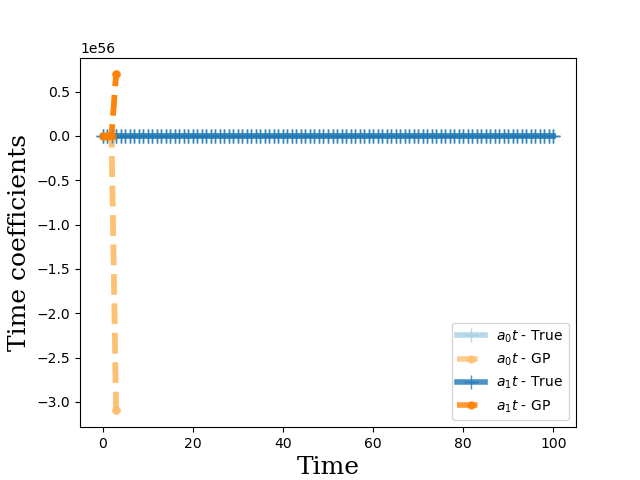

In [8]:
# --------------------------------------------- PLOTS ---------------------------------------------#

font = {
    'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 18,
}

colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']
lines = []
for mode in range(2):
    l, = plt.plot(TIME, TimeCoeff[:, mode], color=colors[mode], linestyle='-', marker='+', linewidth=4, markersize=10, alpha=0.8, label=rf'$a_{mode}{{t}}$ - True')
    l2, = plt.plot(TIME, TimeCoeffGalerkin[:, mode],color=colors[NUM_POD_MODES+mode], linestyle='--', marker='o', linewidth=4, markersize=5, alpha=0.8, label=rf'$a_{mode}{{t}}$ - GP')
    plt.xlabel("Time", fontdict=font)
    plt.ylabel("Time coefficients", fontdict=font)
    lines.append(l)
    lines.append(l2)
plt.legend(handles=lines)
plt.show()


In [ ]:


# if plot_check:
#     # TODO: Fix the mess below :)
#     variable = []
#     variable2 = []
#     for j, tri in enumerate(mesh.triangles):
#         tri.update(TimeStep_DGNu[-1][j], TimeStep_DGNv[-1][j], TimeStep_DGNp[-1][j])
#     for tri in mesh.triangles:
#         var = tri.u_find_first_derivative()
#         var2 = tri.u_find_second_derivative()
#         variable.append(var.x)
#         variable2.append(var2.x)
#     plot_mesh(mesh, variable)
#     plot_mesh(mesh, variable2)
#     plt.show()

    # for i in range(NUM_POD_MODES):
    #     uPOD_ = uPOD[i, :, :]
    #     vPOD_ = vPOD[i, :, :]
    #     variable = []
    #     for j,tri in enumerate(elements):
    #         tri.update(uPOD_[j], vPOD_[j], TimeStep_DGNp[-1][j])
    #     for tri in elements:
    #         var = tri.u_find_first_derivative()
    #         variable.append(var.x)
    #     plot(elements, mesh_Vx, mesh_Vy, variable)

    # relative_importance_content = np.zeros(NUM_TIME_STEPS)
    # total_energy = np.sum(eig_vals)
    # acc = 0
    # for i in range(len(eig_vals)):
    #     acc = acc + eig_vals[i]
    #     relative_importance_content[i] = acc / total_energy * 100

    #     #  Plot first n_modes important eigenvalues

    # figure, axis = plt.subplots(1, 2)
    # axis[0].plot(np.arange(1, NUM_POD_MODES + 1), eig_vals[:NUM_POD_MODES], '-o', color='black', ms=8, alpha=1, mfc='red')
    # axis[0].set_xlabel('k', fontdict=font)
    # axis[0].set_ylabel(r'$λ_{k}$', fontdict=font)
    # axis[0].grid()

    # axis[1].plot(np.arange(1, NUM_POD_MODES + 1),
    #             relative_importance_content[:NUM_POD_MODES],
    #             '-o',
    #             color='black',
    #             ms=8,
    #             alpha=1,
    #             mfc='red')
    # axis[1].set_xlabel('k', fontdict=font)
    # axis[1].set_ylabel(r'$RIC_{k}(\%)$', fontdict=font)
    # axis[1].grid()
    # # plt.savefig('Relative Importance Content.png')
    # plt.show()
